In [1]:
!ls

boolean_subset_structure.ipynb
classifiers_mhcld.ipynb
codebook_descriptions.pickle
deep_learning.ipynb
example.html
google_colab_t-sne_mental_health_client-level_data.ipynb
lib
mhcld_puf_2021.csv
plots
t-sne_k-means_mhcld.ipynb
to_do.txt
unsupervised_learning.ipynb


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
NUM_POINTS = 100_000
data = pd.read_csv("mhcld_puf_2021.csv")
data = data[:NUM_POINTS]

In [4]:
data['SUB'] = data['SUB'].apply(lambda x: 0 if x==-9 else 1)

In [5]:
# Load data the codebook descriptions
import pickle
with open('codebook_descriptions.pickle', 'rb') as handle:
    codebook_descriptions = pickle.load(handle)
assert set(list(data.columns)) == set(list(codebook_descriptions.keys()))

In [6]:
#disorder columns. 0/1 binary. these are dignoses for the disorders
disorder_cols = ['SUB','TRAUSTREFLG','ANXIETYFLG','ADHDFLG','CONDUCTFLG','DELIRDEMFLG','BIPOLARFLG','DEPRESSFLG','ODDFLG','PDDFLG','SCHIZOFLG','PERSONFLG','ALCSUBFLG','OTHERDISFLG']

In [7]:
data[disorder_cols]

,SUB,TRAUSTREFLG,ANXIETYFLG,ADHDFLG,CONDUCTFLG,DELIRDEMFLG,BIPOLARFLG,DEPRESSFLG,ODDFLG,PDDFLG,SCHIZOFLG,PERSONFLG,ALCSUBFLG,OTHERDISFLG
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,1,1,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0,0,0,0,0,0,0,1,0,0,0,0,0,0
99996,0,0,0,0,0,0,0,0,0,0,1,0,0,0
99997,0,0,0,0,0,0,0,0,1,0,0,0,0,0
99998,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
def is_subset(v,w):
    assert len(v) == len(w)
    return [v[i] or w[i] for i in range(len(w))] == w

In [9]:
is_subset([1,1,0],[1,1,0])

True

In [10]:
#create labels for the 13 disorder features
#binary encode them since they are 0/1
#take the total number of disorders present
#create unique leabel for each disorder, plus one for no disorder and one for multiple disorders
#use k-means to automatically label the clusters
def get_labels(dataset, label_type='binary_encode',num_clusters=5):
    labels = []
    for row in dataset[disorder_cols][:NUM_POINTS].itertuples():
        if label_type=='binary_encode':
            #binary number encoding of disorders
            encoding = ''.join([str(row[i]) for i in range(1,len(row))])
            labels.append(encoding)
    return pd.DataFrame(labels,columns=['label']) 

In [11]:
binary_enc_label_df = get_labels(data,label_type='binary_encode')

In [12]:
binary_enc_label_df.value_counts()[:10]

label         
00000001000000    16041
00000000001000    11307
00010000000000     7543
01000000000000     7457
00000010000000     5639
00100000000000     5422
00100001000000     5407
00000000000001     4166
10000000001000     2701
10000001000000     2467
dtype: int64

In [13]:
count_list = binary_enc_label_df.value_counts().to_list()

In [14]:
multidisorder_list = [item[0] for item in list(binary_enc_label_df.value_counts().index)]

In [15]:
multidisorder_vec_list = [list(map(int,[*item])) for item in multidisorder_list]

In [16]:
boolean_subset_adj_matrix = np.array([[int(is_subset(v,w)) for v in multidisorder_vec_list] for w in multidisorder_vec_list])

In [49]:
MAX_DISORDERS = 50

In [18]:
#only use the subset relation if the number of disorders is one less than the containing multidisorder
#this prevents having two arrows for things like 100 --> 110 and 100 --> 111. it's unnecessary since 100 --> 110 --> 111.
truncated_leveled_boolean_subset_adj_matrix = np.array([[int(is_subset(v,w) and sum(v)+1 == sum(w)) for v in multidisorder_vec_list[:MAX_DISORDERS]] for w in multidisorder_vec_list[:MAX_DISORDERS]])

In [19]:
truncated_leveled_boolean_subset_adj_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

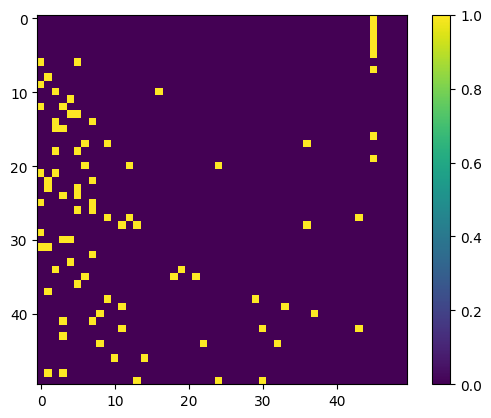

In [20]:
plt.imshow(truncated_leveled_boolean_subset_adj_matrix)
plt.colorbar()
plt.show()

In [50]:
def labels_of_len(k): return [''.join([str(x) for x in item]) for item in multidisorder_vec_list[:MAX_DISORDERS] if sum(item) == k ]

In [43]:
import string
def label_abbrv(label):
    return ''.join([string.ascii_uppercase[i] for i in range(len(label)) if label[i] == '1'])

In [22]:
import networkx as nx

In [53]:
G = nx.from_numpy_array(truncated_leveled_boolean_subset_adj_matrix)

In [54]:
G = nx.relabel_nodes(G,{i:label_abbrv(multidisorder_list[i]) for i in range(len(multidisorder_list[:MAX_DISORDERS]))})

In [59]:
labels_len_0 = list(map(label_abbrv,labels_of_len(0)))
labels_len_1 = list(map(label_abbrv,labels_of_len(1)))
labels_len_2 = list(map(label_abbrv,labels_of_len(2)))
labels_len_3 = list(map(label_abbrv,labels_of_len(3)))
labels_len_4 = list(map(label_abbrv,labels_of_len(4)))

In [71]:
pos0 = {labels_len_0[i]:(i,0) for i in range(len(labels_len_0))}
pos1 = {labels_len_1[i]:(i,1) for i in range(len(labels_len_1))}
pos2 = {labels_len_2[i]:(i,2) for i in range(len(labels_len_2))}
pos3 = {labels_len_3[i]:(1.3*i,3) for i in range(len(labels_len_3))}
pos4 = {labels_len_4[i]:(i,4) for i in range(len(labels_len_4))}

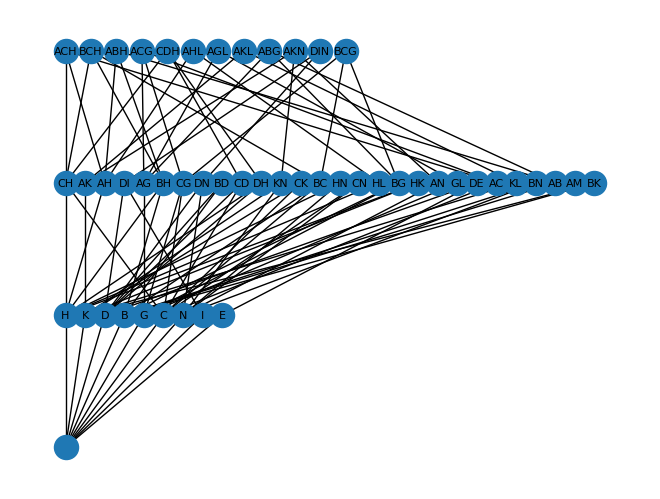

In [79]:
nx.draw(G, with_labels=True, pos=pos0|pos1|pos2|pos3|pos4, font_size=8)
plt.show()

In [85]:
{string.ascii_uppercase[i]:codebook_descriptions[disorder_cols[i]] for i in range(14)}

{'A': 'Substance use diagnosis',
 'B': 'Trauma- or stressor-related disorder reported',
 'C': 'Anxiety disorder reported',
 'D': 'Attention deficit/hyperactivity disorder reported',
 'E': 'Conduct disorder reported',
 'F': 'Delirium/dementia disorder reported',
 'G': 'Bipolar disorder reported',
 'H': 'Depressive disorder reported',
 'I': 'Oppositional defiant disorder reported',
 'J': 'Pervasive developmental disorder reported',
 'K': 'Schizophrenia or other psychotic disorder reported',
 'L': 'Personality disorder reported',
 'M': 'Alcohol or substance-related disorder reported',
 'N': 'Other mental disorder reported'}